In [127]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

In [ ]:
model_name = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(
    model_name, num_labels=2
)
model_version = "vanilla"

model.save_pretrained(f"./{model_version}/model")
tokenizer.save_pretrained(f"./{model_version}/model")

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


('./vanilla/model/tokenizer_config.json',
 './vanilla/model/special_tokens_map.json',
 './vanilla/model/vocab.txt',
 './vanilla/model/added_tokens.json',
 './vanilla/model/tokenizer.json')

In [129]:
output_dir = f"./{model_version}/checkpoints"
model_path = f"./{model_version}/model"
subm_path = f"./{model_version}/submission.csv"

In [ ]:
def get_token_gradients(text, model_path="", target_class=1, max_length=128):
    """
    Gradients backpropagated to an input

    """
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForSequenceClassification.from_pretrained(model_path)
    model.eval()

    inputs = tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=max_length,
    )
    input_ids = inputs["input_ids"]
    attention_mask = inputs["attention_mask"]

    embeddings = model.distilbert.embeddings.word_embeddings(input_ids)

    embeddings.requires_grad_(True)
    embeddings.retain_grad()

    outputs = model(inputs_embeds=embeddings, attention_mask=attention_mask)
    target_logit = outputs.logits[:, target_class].squeeze()

    target_logit.backward()

    grad = embeddings.grad.detach().squeeze(0)

    grad_norms = grad.norm(dim=1)
    grad_norms = grad_norms / grad_norms.max()

    tokens = tokenizer.convert_ids_to_tokens(input_ids.squeeze().tolist())

    return tokens, grad_norms


def print_gradient_norms(tokens_and_grads):
    tokens = tokens_and_grads[0]
    grad_norms = tokens_and_grads[1]
    for token, norm in zip(tokens, grad_norms):
        if token not in ["[CLS]", "[SEP]", "[PAD]"]:
            print(f"{token}: {norm.item():.4f}")


def inspect_gradient(text: str, model_path="./model"):
    print(f"Text: {text}\n-------------\n")
    tokens_and_grads = get_token_gradients(text, model_path=model_path)
    print_gradient_norms(tokens_and_grads)
    print("-------------\n")


def plot_token_gradients(
    tokens,
    grad_norms,
    skip_tokens=["[CLS]", "[SEP]", "[PAD]"],
    label="Gradient Norms for Tokens",
):
    """
    Plots the tokens on a horizontal line using a temperature scale ('hot' colormap),
    where the intensity reflects the normalized gradient norm (higher values are 'hotter').
    """
    fig, ax = plt.subplots(figsize=(12, 2))
    ax.axis("off")

    cmap = plt.cm.coolwarm
    norm = mcolors.Normalize(vmin=0, vmax=1)

    x = 0.01
    y = 0.5
    spacing = 0.06

    for token, grad in zip(tokens, grad_norms):
        if token in skip_tokens:
            continue
        color = cmap(norm(grad.item()))
        ax.text(
            x,
            y,
            token,
            fontsize=12,
            fontweight="bold",
            bbox=dict(
                facecolor=color, edgecolor="none", boxstyle="round,pad=0.2"
            ),
            transform=ax.transAxes,
        )
        x += spacing
    fig.suptitle(label, fontsize=12)
    return fig

In [131]:
model_version = "vanilla"
sample_text = "In this recipe we cook tofu and beef while riding a bicycle."
inspect_gradient(text=sample_text, model_path=f"./{model_version}/model")

Text: In this recipe we cook tofu and beef while riding a bicycle.
-------------

in: 0.4558
this: 0.4630
recipe: 1.0000
we: 0.7535
cook: 0.7675
to: 0.4357
##fu: 0.9230
and: 0.3021
beef: 0.5396
while: 0.2930
riding: 0.3264
a: 0.2595
bicycle: 0.6067
.: 0.4224
-------------



In [132]:
model_version = "subm2_2"

sample_text = "In this recipe we cook tofu and beef while riding a bicycle."
inspect_gradient(text=sample_text, model_path=f"./{model_version}/model")

Text: In this recipe we cook tofu and beef while riding a bicycle.
-------------

in: 0.1107
this: 0.1487
recipe: 0.4791
we: 0.1735
cook: 0.2397
to: 0.2502
##fu: 0.4946
and: 0.5586
beef: 1.0000
while: 0.3253
riding: 0.1755
a: 0.1056
bicycle: 0.2459
.: 0.0973
-------------



In [133]:
model_version = "subm2_newtokenizer"

sample_text = "In this recipe we cook tofu and beef while riding a bicycle."
inspect_gradient(sample_text, model_path=f"./{model_version}/model")

Text: In this recipe we cook tofu and beef while riding a bicycle.
-------------

in: 0.0388
this: 0.0303
recipe: 0.0518
we: 0.0696
cook: 0.0497
tofu: 0.5584
and: 0.0409
beef: 1.0000
while: 0.0595
rid: 0.1025
##ing: 0.0476
a: 0.0526
bi: 0.1589
##cy: 0.0872
##cle: 0.2274
.: 0.0411
-------------



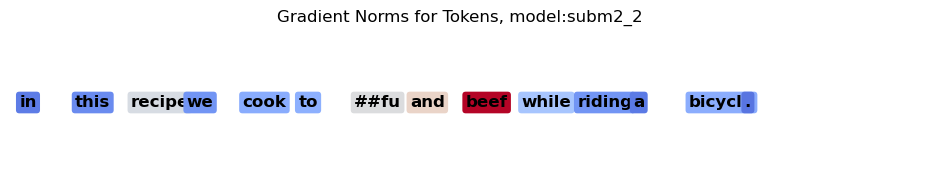

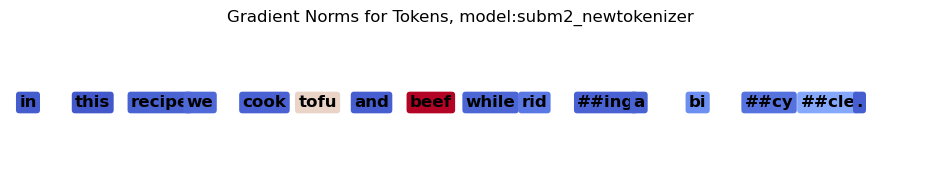

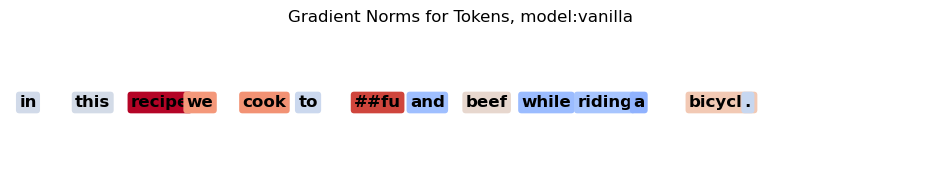

In [134]:
model_versions = ["subm2_2", "subm2_newtokenizer", "vanilla"]

for model_version in model_versions:
    sample_text = (
        "In this recipe we cook tofu and beef while riding a bicycle."
    )
    tokens, grad_norms = get_token_gradients(
        sample_text, model_path=f"./{model_version}/model"
    )

    gradient_fig = plot_token_gradients(
        tokens,
        grad_norms,
        label=f"Gradient Norms for Tokens, model:{model_version}",
    )
    gradient_fig.savefig(f"./{model_version}/gradient_{model_version}.pdf")